# Memory Schema and Collection

## Defining a collection schema

Instead of storing user information in a fixed profile structure, we'll create a flexible collection schema to store memories about user interactions.

Each memory will be stored as a separate entry with a single content field for the main information we want to remember

This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

We can define a collection schema as a Pydantic object.

In [12]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from the environment
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    print("Groq API key is not set in the environment variables.")
else:
    print("Groq API key successfully loaded.")

Groq API key successfully loaded.


In [37]:
import warnings 
warnings.filterwarnings("ignore")

In [13]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-2.5-32b",temperature=0)

In [14]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [15]:
from langchain_core.messages import HumanMessage

# Bind schema to model
model_with_structure = llm.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Zeeshan. I like to bike.")])
memory_collection.memories

[Memory(content='User named Zeeshan likes to bike.')]

In [16]:
memory_collection.memories[0].model_dump()

{'content': 'User named Zeeshan likes to bike.'}

In [ ]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [19]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'content': 'User named Zeeshan likes to bike.'}, 'key': '03e942b9-8521-47c2-833b-ed3121726d04', 'namespace': ['1', 'memories'], 'created_at': '2025-02-13T16:54:33.819904+00:00', 'updated_at': '2025-02-13T16:54:33.819908+00:00', 'score': None}


## Updating collection schema


In [21]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Zeeshan."), 
                AIMessage(content="Nice to meet you, Zeeshan."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [ ]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

## Chatbot with collection schema updating


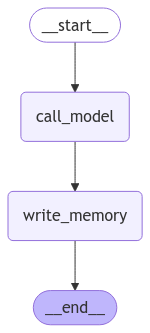

In [27]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
llm = ChatGroq(model="qwen-2.5-32b",temperature=0)
# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [36]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Zeeshan")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Zeeshan
================================== Ai Message ==================================

Hello Zeeshan! It's great to see you again. How can I assist you today? Do you want to talk more about your favorite places to bike or bakeries in San Francisco?


BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}

In [29]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore San Francisco! The city has some beautiful bike routes and paths. Are there any particular areas or parks you enjoy biking through? Also, do you have any favorite bike trails or spots you recommend?


BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}

In [30]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

In [31]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That's awesome, Zeeshan! San Francisco is known for its fantastic bakeries. Do you have any favorite bakeries you like to visit? If you're looking for recommendations, some popular ones include Tartine Bakery, Boudin Bakery, and Bi-Rite Bakery. Let me know if you want more suggestions or specific details about these places!


BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()




================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Sure, I can provide some recommendations, but it would be helpful to know your location and any specific preferences you might have. Here are some popular and highly-regarded bakeries that you might enjoy:

1. **Le Pain Quotidien** - Known for their organic and wholesome breads, pastries, and sandwiches. They have locations worldwide.
2. **Stella's Bakery** - Famous for their bagels and other baked goods, particularly popular in the New York area.
3. **Sweetooth Bakery** - Known for their cupcakes and other sweet treats, with locations in various states.
4. **Balthazar Bakery** - Part of the Balthazar restaurant in New York City, known for their croissants and other French pastries.
5. **Dough** - A popular bakery chain known for their artisan breads and pastries, with locations in mult

BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}